<a href="https://colab.research.google.com/github/zeligism/ConGAN/blob/main/CubicOneShotSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Download datasets

In [26]:
%%bash
# Download some regression datasets
DATASETS=("abalone" "bodyfat" "cpusmall" "housing" "mg" "mpg" "space_ga")
BASE_LINK="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression"
for dataset in "${DATASETS[@]}"
    do [[ ! -f "${dataset}" ]] && wget -O "${dataset}" "${BASE_LINK}/${dataset}_scale"
done

In [27]:
DATASET_FEATURES = {
    "abalone": 8,
    "bodyfat": 14,
    "cpusmall": 12,
    "housing": 13,
    "mg": 6,
    "mpg": 7,
    "space_ga": 6,
}

## Args

In [28]:
# Easy to transfer to code using argparse
class Args:
    def __init__(self):
        self.dataset = "cpusmall"
        self.feature_dim = DATASET_FEATURES[self.dataset]
        self.output_dim = 1
        self.device = "cuda:0"
        self.test_size = 0.2

        self.num_models = 10
        self.num_iters = 100
        self.base_lr = 1e-2
        self.lrs = [self.base_lr] * self.num_models
        self.batch_size = 1

args = Args()

In [29]:
!echo "{args.dataset}:" && head "{args.dataset}"

cpusmall:
90 1:-0.993496 2:-0.993043 3:-0.850291 4:-0.963479 5:-0.960727 6:-0.900596 7:-0.96642 8:-0.863996 9:-0.606175 10:-0.999291 11:0.0811894 12:0.651101 
88 1:-0.998916 2:-1 3:-0.667959 4:-0.925075 5:-0.965498 6:-0.960239 7:-0.959704 8:-0.966094 9:-0.952624 10:-0.998583 11:-0.987471 12:0.00921591 
85 1:-0.932791 2:-0.732174 3:-0.402939 4:-0.90512 5:-0.941641 6:-0.860835 7:-0.952989 8:-0.610616 9:-0.703123 10:-0.997023 11:-0.966422 12:0.172073 
81 1:-0.99458 2:-1 3:-0.255168 4:-0.905873 5:-0.937603 6:-0.90159 7:-0.913365 8:-0.584773 9:-0.807273 10:-1 11:-0.970264 12:-0.132837 
79 1:-0.954472 2:-0.808696 3:-0.379845 4:-0.908509 5:-0.913012 6:-0.741551 7:-0.845534 8:-0.844036 9:-0.413705 10:-0.998299 11:-0.953892 12:-0.096104 
92 1:-0.99458 2:-0.996522 3:-0.744348 4:-0.95256 5:-0.970637 6:-0.960239 7:-0.939557 8:-0.825904 9:-0.882749 10:-0.99915 11:-0.626462 12:-0.0988697 
82 1:-0.996748 2:-1 3:-0.915052 4:-0.977786 5:-0.985318 6:-0.701789 7:-0.899261 8:-0.930978 9:-0.956401 10:-1 11

## Dataset

In [30]:
from sklearn.datasets import load_svmlight_file

class MyDataset(data_utils.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        with open(self.dataset, "rb") as f:
            self.X, self.y = load_svmlight_file(f)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X_tensor = torch.Tensor(self.X[idx].todense()).squeeze(0)
        y_tensor = torch.Tensor([self.y[idx]]).squeeze(0)
        return X_tensor, y_tensor

class DataSampler:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.reset_sampler()

    def reset_sampler(self):
        self.sampler = iter(self.dataloader)

    def sample(self):
        try:
            x, y = next(self.sampler)
        except StopIteration:
            self.reset_sampler()
            x, y = next(self.sampler)
        return x, y

## Optimizer

In [31]:
class LocalSGD(torch.optim.SGD):
    def aggregate(self):
        # This function simply averages parameters across all groups/models
        num_models = len(self.param_groups)
        num_params = len(self.param_groups[0]["params"])
        aggregated_params = [None] * num_params
        # Find average per parameter
        for param_idx in range(num_params):
            param_list = [self.param_groups[model_idx]["params"][param_idx].data
                          for model_idx in range(num_models)]
            aggregated_params[param_idx] = torch.mean(torch.stack(param_list))
        # Synchronize
        for model_idx in range(num_models):
            for param_idx in range(num_params):
                self.param_groups[model_idx]["params"][param_idx] = aggregated_params[param_idx]

### Aggregation Schedule

In [32]:
# The schedule is just the iterations in which we aggregate
def n_shot_schedule(N, T):
    return {i for i in range(T-1, 0, -T // N)}

aggregation_idxs = n_shot_schedule(1, args.num_iters)
aggregation_idxs

{99}

## Model

In [33]:
def create_model():
    return nn.Linear(args.feature_dim, args.output_dim)

# Training

Train prep

In [34]:
dataset = MyDataset(args.dataset)
test_len = int(args.test_size * len(dataset))
trainset, testset = data_utils.random_split(dataset, [len(dataset) - test_len, test_len])
trainloader = data_utils.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, pin_memory=True)
testloader = data_utils.DataLoader(testset, batch_size=len(testset), shuffle=False, pin_memory=True)

# Define a group of models (optimized in parallel) and a singled out model (optimized alone)
one_model = create_model().to(device=args.device)
one_optimizer = torch.optim.SGD(one_model.parameters(), lr=args.base_lr)
models = [create_model().to(device=args.device) for i in range(args.num_models)]
param_groups = [{"params": models[i].parameters(), "lr": args.lrs[i]} for i in range(args.num_models)]
optimizer = LocalSGD(param_groups, lr=args.base_lr)

# MSE loss
loss_fn = nn.MSELoss().to(device=args.device)

In [35]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [36]:
def validate(testloader, model):
    running_loss = 0.0
    running_acc = 0
    for x, y in testloader:
        x = x.to(device=args.device)
        y = y.to(device=args.device)
        y_pred = model(x).view_as(y)
        loss = loss_fn(y_pred, y)
        acc = torch.sum(y_pred.round() == y) / y.size(0)
        running_loss += loss.item()
        running_acc += acc.item()
    mean_loss = running_loss / len(testloader)
    mean_acc = running_acc / len(testloader)
    return mean_loss, mean_acc

def train(trainloader, testloader, models, one_model,
          optimizer, one_optimizer, loss_fn, aggregation_idxs, T, track_model="best"):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    train_losses = AverageMeter("train_loss", ":.4f")
    val_losses = AverageMeter("val_loss", ":.4f")
    one_train_losses = AverageMeter("one_train_loss", ":.4f")
    one_val_losses = AverageMeter("one_val_loss", ":.4f")
    progress = ProgressMeter(T, [train_losses, val_losses, one_train_losses, one_val_losses])

    for t in range(T):
        model_losses = []
        # model loop should be run in parallel
        for model in models:
            x, y = data_sampler.sample() # assuming a central dataset
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            # Train each model
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            model_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train the singled out model in every step
            y_pred = one_model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            one_train_loss = loss.item()
            one_optimizer.zero_grad()
            loss.backward()
            one_optimizer.step()
        # Aggregate the gradient steps by averaging the parameters
        if t in aggregation_idxs:
            print("Aggregating parameters...")
            optimizer.aggregate()
        
        # Track min model loss?
        if track_model == "best":
            train_loss = min(model_losses)
            model_idx = model_losses.index(train_loss)
        elif track_model == "random":
            model_idx = np.random.randint(len(models))
            train_loss = model_losses[model_idx]
        elif isinstance(track_model, int) and track_model in range(len(models)):
            model_idx = track_model
            train_loss = model_losses[model_idx]
        else:
            raise Exception(f"track_model '{track_model}' not found.")

        # Validation
        train_losses.update(train_loss)
        one_train_losses.update(one_train_loss)
        val_loss, _ = validate(testloader, models[model_idx])
        one_val_loss, _ = validate(testloader, one_model)
        val_losses.update(val_loss)
        one_val_losses.update(one_val_loss)
        progress.display(t)

        stats["train_loss"] += [train_loss]
        stats["val_loss"] += [val_loss]
        stats["one_train_loss"] += [one_train_loss]
        stats["one_val_loss"] += [one_val_loss]
        #print(f"[{t}/{T}]" + " ".join(f"{k} = {v[-1]:.4f}" for k, v in stats.items()))
    
    return stats

stats = train(trainloader, testloader,
              models, one_model, optimizer, one_optimizer, loss_fn,
              aggregation_idxs, args.num_iters)

[  0/100]	train_loss 5577.1958 (5577.1958)	val_loss 5332.0830 (5332.0830)	one_train_loss 46.0541 (46.0541)	one_val_loss 293.3694 (293.3694)
[  1/100]	train_loss 2846.4146 (4211.8052)	val_loss 3362.5754 (4347.3292)	one_train_loss 27.3343 (36.6942)	one_val_loss 234.2385 (263.8039)
[  2/100]	train_loss 833.6352 (3085.7485)	val_loss 4244.8228 (4313.1604)	one_train_loss 11.7030 (28.3638)	one_val_loss 215.8836 (247.8305)
[  3/100]	train_loss 983.6738 (2560.2298)	val_loss 2404.0840 (3835.8913)	one_train_loss 95.7324 (45.2060)	one_val_loss 214.9976 (239.6223)
[  4/100]	train_loss 844.0026 (2216.9844)	val_loss 1046.6838 (3278.0498)	one_train_loss 14.7268 (39.1101)	one_val_loss 208.8945 (233.4767)
[  5/100]	train_loss 281.2109 (1894.3555)	val_loss 859.9387 (2875.0313)	one_train_loss 8.9538 (34.0841)	one_val_loss 206.9953 (229.0632)
[  6/100]	train_loss 0.3377 (1623.7815)	val_loss 616.7518 (2552.4199)	one_train_loss 0.0035 (29.2154)	one_val_loss 199.2384 (224.8025)
[  7/100]	train_loss 35.1748 (1

# Results

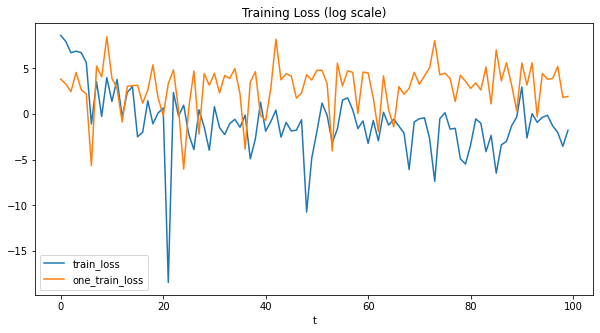

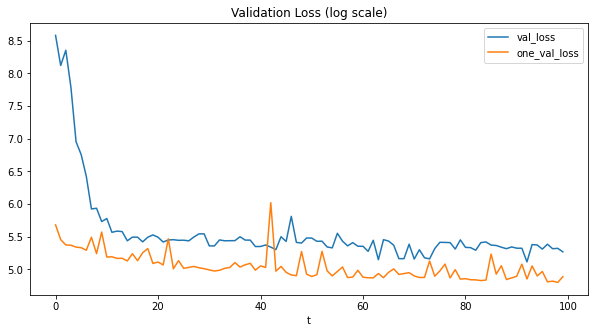

In [37]:
from math import log
log_scale = True

def plot_lines(losses_dict, title="", filename=None, ):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()

apply_log = lambda v: list(map(log, v))
train_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "train_loss" in k}
val_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "val_loss" in k}
accuracies = {k: v for k, v in stats.items() if "acc" in k}
plot_lines(train_losses, "Training Loss" + (" (log scale)" if log_scale else ""))
plot_lines(val_losses, "Validation Loss" + (" (log scale)" if log_scale else ""))
#plot_lines(accuracies, "Accuracy")